# Lab 3 Solutions (just code, because I ran out of time)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re

## Part 1

In [2]:
def get_airport_html(code):
    url = f'https://flightaware.com/live/airport/K{code}'
    return requests.get(url).text

url_text = get_airport_html('BOS')

## Part 2

In [3]:
def get_airport_table_soup(html, board):
    big_soup = BeautifulSoup(html)
    soup = big_soup.find_all(id=board)[0]
    return soup

arrivals = get_airport_table_soup(url_text, 'arrivals-board')

## Part 3

In [4]:
def clean_board_df(soup):
    names = soup.find_all('span', attrs = {'title':True})
    flight_number = []
    aircraft_type = []
    airport_name = []
    for idx in range(0, len(names), 3):
        flight_number.append(names[idx].text)
        aircraft_type.append(names[idx+1].text)
        airport_name.append(names[idx+2].text)
        
    codes = soup.find_all(attrs = {'dir': 'ltr'})
    airport_code = []
    for idx in range(0, len(codes), 2):
        airport_code.append(codes[idx+1].text.replace("(", "").replace(")", ""))
    
    times = soup.find_all(class_='tz')
    departure_time = []
    arrival_time = []
    for idx in range(0, len(times), 2):
        dep_split_string = times[idx].previous_sibling.split('\xa0')
        arr_split_string = times[idx+1].previous_sibling.split('\xa0')
        
        if dep_split_string[0].endswith('a') == True:
            dep_datetime_str = dep_split_string[0][:-1] + ' AM'
            dep_datetime_time = datetime.strptime(dep_datetime_str, '%I:%M %p').time()
            departure_time.append(dep_datetime_time)
        else:
            dep_datetime_str = dep_split_string[0][:-1] + ' PM'
            dep_datetime_time = datetime.strptime(dep_datetime_str, '%I:%M %p').time()
            departure_time.append(dep_datetime_time)
        
        if arr_split_string[0].endswith('a') == True:
            arr_datetime_str = arr_split_string[0][:-1] + ' AM'
            arr_datetime_time = datetime.strptime(arr_datetime_str, '%I:%M %p').time()
            arrival_time.append(arr_datetime_time)
        else:
            arr_datetime_str = arr_split_string[0][:-1] + ' PM'
            arr_datetime_time = datetime.strptime(arr_datetime_str, '%I:%M %p').time()
            arrival_time.append(arr_datetime_time)
    
    clean_board_dict = {'flight number': flight_number,
                        'aircraft type': aircraft_type,
                        'airport name': airport_name,
                        'airport code': airport_code,
                        'departure time': departure_time,
                        'arrival time': arrival_time}
    clean_board_df = pd.DataFrame.from_dict(clean_board_dict)
    
    return clean_board_df
    
clean_df = clean_board_df(arrivals)

## Part 4

In [5]:
def get_aircraft_info(clean_df):
    aircraft_type = list(clean_df['aircraft type'])
    num_type = []
    for idx in range(len(aircraft_type)):
        craft_url = f'https://flightaware.com/live/aircrafttype/{aircraft_type[idx]}'
        craft_tables = pd.read_html(craft_url)
        num_type.append(craft_tables[2].shape[0])
        
    clean_df['num type'] = pd.Series(num_type)
    
    return clean_df

final_df = get_aircraft_info(clean_df)

## Part 5

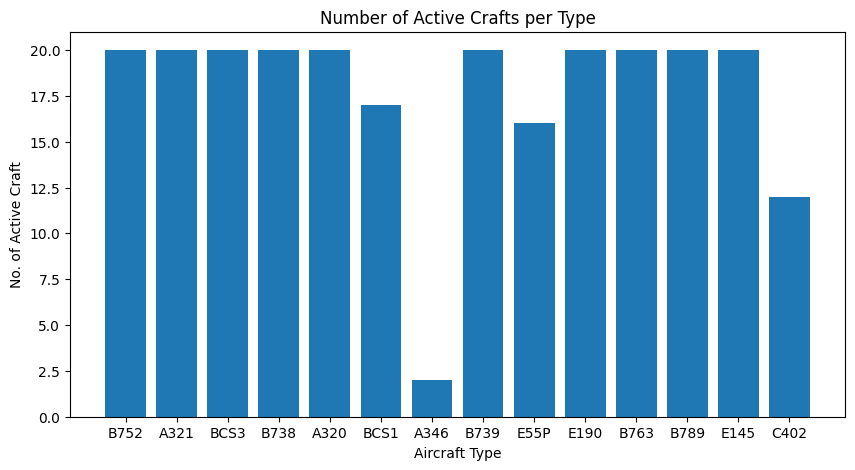

In [7]:
types = list(final_df['aircraft type'])
num = list(final_df['num type'])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(types, num)
 
plt.xlabel("Aircraft Type")
plt.ylabel("No. of Active Craft")
plt.title("Number of Active Crafts per Type")
plt.show()